In [ ]:
import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split


import torch
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import ASTForAudioClassification, AutoProcessor
from tqdm import tqdm
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from datetime import datetime
import json




In [2]:
Ravdess = "/mnt/c/Users/mafro/Desktop/Emotions DataSets/Ravdess/"
Crema   = "/mnt/c/Users/mafro/Desktop/Emotions DataSets/Crema/AudioWAV/"
Tess    = "/mnt/c/Users/mafro/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/"
Savee   = "/mnt/c/Users/mafro/Desktop/Emotions DataSets/Savee/ALL/"

<h1>Ravdess</h1>

In [ ]:

ravdess_directory_list = [d for d in os.listdir(Ravdess) if d.startswith("Actor_")]

file_emotion = []
file_path = []

for dir in ravdess_directory_list:
    actor_folder = os.path.join(Ravdess, dir)
    
    for file in os.listdir(actor_folder):
        if not file.endswith('.wav'):
            continue  
        
        part = file.split('.')[0].split('-')
        
        if len(part) != 7:
            print(f"⚠️ Skipping malformed file: {file}")
            continue
        
        try:
            emotion_code = int(part[2])
            file_emotion.append(emotion_code)
            file_path.append(os.path.join(actor_folder, file))
        except ValueError:
            print(f"❌ Couldn't parse emotion code in: {file}")


emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)


emotion_labels = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}
Ravdess_df["Emotions"] = Ravdess_df["Emotions"].map(emotion_labels)

print(Ravdess_df.head())
print(Ravdess_df["Path"].values[1])

  Emotions                                               Path
0  neutral  /mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
1  neutral  /mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
2  neutral  /mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
3  neutral  /mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
4     calm  /mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
/mnt/c/Users/mafro/Desktop/Emotions DataSets/Ravdess/Actor_01/03-01-01-01-01-02-01.wav


<h1>Crema</h1>

In [ ]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)

    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df["Path"].values[1])

/mnt/c/Users/mafro/Desktop/Emotions DataSets/Crema/AudioWAV/1001_DFA_DIS_XX.wav


In [5]:
emotion_df

,Emotions
0,angry
1,disgust
2,fear
3,happy
4,neutral
...,...
7437,disgust
7438,fear
7439,happy
7440,neutral


<h1>TESS</h1>

In [ ]:
tess_directory_list = os.listdir(Tess)
file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + "/"+dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]

        if part=='ps':
            file_emotion.append('surprise')
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()
print(Tess_df['Path'].values[1])

/mnt/c/Users/mafro/Desktop/Emotions DataSets/Tess/TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav


<h1>Savee</h1>

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])


path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()
print(Savee_df["Path"].values[1])

/mnt/c/Users/mafro/Desktop/Emotions DataSets/Savee/ALL/DC_a02.wav


In [8]:
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
data_path.to_csv("data_path.csv",index=False)
data_path


,Emotions,Path
0,neutral,/mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
1,neutral,/mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
2,neutral,/mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
3,neutral,/mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
4,calm,/mnt/c/Users/mafro/Desktop/Emotions DataSets/R...
...,...,...
475,surprise,/mnt/c/Users/mafro/Desktop/Emotions DataSets/S...
476,surprise,/mnt/c/Users/mafro/Desktop/Emotions DataSets/S...
477,surprise,/mnt/c/Users/mafro/Desktop/Emotions DataSets/S...
478,surprise,/mnt/c/Users/mafro/Desktop/Emotions DataSets/S...


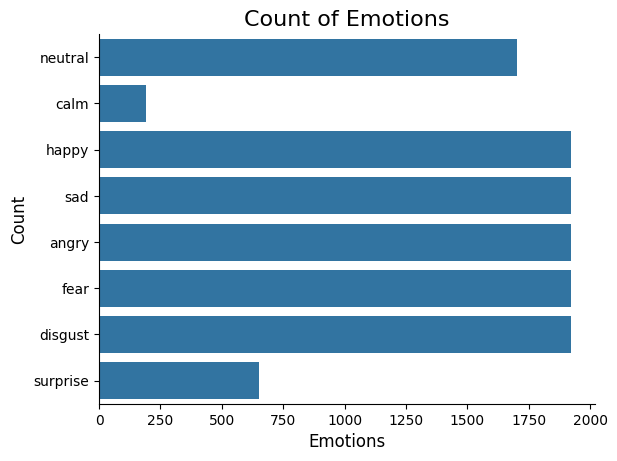

In [9]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

2025-04-16 20:10:01.077001: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-16 20:10:01.228023: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-16 20:10:01.270178: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-16 20:10:01.574975: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-16 20:10:03.298522: W tensorflow/compiler/tf2


Epoch 1/30


Epoch 1, Loss: 2.0318, Accuracy: 16.70%


Validation Loss: 1.9741, Accuracy: 20.35%
F1 Score: 0.1396
              precision    recall  f1-score   support

       angry     0.3846    0.0519    0.0915       385
        calm     0.0969    1.0000    0.1767        38
     disgust     0.4444    0.0104    0.0203       385
        fear     0.2754    0.3870    0.3218       385
       happy     0.0000    0.0000    0.0000       385
     neutral     0.2315    0.5529    0.3264       340
         sad     0.2121    0.0364    0.0621       385
    surprise     0.1475    0.6308    0.2391       130

    accuracy                         0.2035      2433
   macro avg     0.2241    0.3337    0.1547      2433
weighted avg     0.2501    0.2035    0.1396      2433

✅ Checkpoint saved at epoch 1

Epoch 2/30


Epoch 2, Loss: 1.9332, Accuracy: 24.12%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.9077, Accuracy: 28.61%
F1 Score: 0.1972
              precision    recall  f1-score   support

       angry     0.3852    0.2701    0.3176       385
        calm     0.1418    1.0000    0.2484        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.3079    0.6078    0.4087       385
       happy     0.0000    0.0000    0.0000       385
     neutral     0.2620    0.6912    0.3800       340
         sad     1.0000    0.0026    0.0052       385
    surprise     0.3544    0.6462    0.4578       130

    accuracy                         0.2861      2433
   macro avg     0.3064    0.4022    0.2272      2433
weighted avg     0.3257    0.2861    0.1972      2433

✅ Checkpoint saved at epoch 2

Epoch 3/30


Epoch 3, Loss: 1.8844, Accuracy: 31.12%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.8704, Accuracy: 34.07%
F1 Score: 0.2922
              precision    recall  f1-score   support

       angry     0.3886    0.4260    0.4064       385
        calm     0.1538    1.0000    0.2667        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.3305    0.6052    0.4275       385
       happy     0.3701    0.1481    0.2115       385
     neutral     0.3540    0.5529    0.4317       340
         sad     0.4380    0.1558    0.2299       385
    surprise     0.3755    0.6846    0.4850       130

    accuracy                         0.3407      2433
   macro avg     0.3013    0.4466    0.3073      2433
weighted avg     0.3136    0.3407    0.2922      2433

✅ Checkpoint saved at epoch 3

Epoch 4/30


Epoch 4, Loss: 1.8455, Accuracy: 36.68%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.8408, Accuracy: 37.16%
F1 Score: 0.3301
              precision    recall  f1-score   support

       angry     0.4222    0.4935    0.4551       385
        calm     0.1784    1.0000    0.3028        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.3720    0.5169    0.4326       385
       happy     0.4078    0.1896    0.2589       385
     neutral     0.3856    0.5500    0.4533       340
         sad     0.3774    0.3039    0.3367       385
    surprise     0.3831    0.7692    0.5115       130

    accuracy                         0.3716      2433
   macro avg     0.3158    0.4779    0.3439      2433
weighted avg     0.3271    0.3716    0.3301      2433

✅ Checkpoint saved at epoch 4

Epoch 5/30


Epoch 5, Loss: 1.8184, Accuracy: 39.47%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.8166, Accuracy: 40.40%
F1 Score: 0.3631
              precision    recall  f1-score   support

       angry     0.4560    0.5922    0.5153       385
        calm     0.1854    1.0000    0.3128        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.4458    0.4597    0.4527       385
       happy     0.3756    0.2078    0.2676       385
     neutral     0.4345    0.5265    0.4761       340
         sad     0.3884    0.4701    0.4254       385
    surprise     0.4167    0.7692    0.5405       130

    accuracy                         0.4040      2433
   macro avg     0.3378    0.5032    0.3738      2433
weighted avg     0.3495    0.4040    0.3631      2433

✅ Checkpoint saved at epoch 5

Epoch 6/30


Epoch 6, Loss: 1.7954, Accuracy: 41.80%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.7998, Accuracy: 41.68%
F1 Score: 0.3723
              precision    recall  f1-score   support

       angry     0.5000    0.5844    0.5389       385
        calm     0.1949    1.0000    0.3262        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.4893    0.4156    0.4494       385
       happy     0.3769    0.1948    0.2568       385
     neutral     0.3931    0.6382    0.4865       340
         sad     0.4295    0.4987    0.4615       385
    surprise     0.4068    0.8231    0.5445       130

    accuracy                         0.4168      2433
   macro avg     0.3488    0.5194    0.3830      2433
weighted avg     0.3639    0.4168    0.3723      2433

✅ Checkpoint saved at epoch 6

Epoch 7/30


Epoch 7, Loss: 1.7801, Accuracy: 43.69%


/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/robert/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

Validation Loss: 1.7871, Accuracy: 42.58%
F1 Score: 0.3825
              precision    recall  f1-score   support

       angry     0.5215    0.5974    0.5569       385
        calm     0.2289    1.0000    0.3725        38
     disgust     0.0000    0.0000    0.0000       385
        fear     0.4860    0.4052    0.4419       385
       happy     0.3605    0.2416    0.2893       385
     neutral     0.4286    0.5912    0.4969       340
         sad     0.4280    0.5403    0.4776       385
    surprise     0.3767    0.8462    0.5213       130

    accuracy                         0.4258      2433
   macro avg     0.3538    0.5277    0.3946      2433
weighted avg     0.3678    0.4258    0.3825      2433

✅ Checkpoint saved at epoch 7

Epoch 8/30


Epoch 8, Loss: 1.7652, Accuracy: 44.62%


Validation Loss: 1.7752, Accuracy: 43.32%
F1 Score: 0.3891
              precision    recall  f1-score   support

       angry     0.5244    0.6416    0.5771       385
        calm     0.2043    1.0000    0.3393        38
     disgust     1.0000    0.0078    0.0155       385
        fear     0.4888    0.3974    0.4384       385
       happy     0.3836    0.2182    0.2781       385
     neutral     0.4389    0.6235    0.5152       340
         sad     0.4283    0.5429    0.4788       385
    surprise     0.4000    0.8308    0.5400       130

    accuracy                         0.4332      2433
   macro avg     0.4835    0.5328    0.3978      2433
weighted avg     0.5329    0.4332    0.3891      2433

✅ Checkpoint saved at epoch 8

Epoch 9/30


Epoch 9, Loss: 1.7527, Accuracy: 46.38%


Validation Loss: 1.7642, Accuracy: 46.20%
F1 Score: 0.4415
              precision    recall  f1-score   support

       angry     0.5846    0.6104    0.5972       385
        calm     0.2405    1.0000    0.3878        38
     disgust     0.8077    0.1636    0.2721       385
        fear     0.4689    0.4312    0.4493       385
       happy     0.3837    0.2442    0.2984       385
     neutral     0.4458    0.6412    0.5259       340
         sad     0.4529    0.5117    0.4805       385
    surprise     0.4154    0.8692    0.5622       130

    accuracy                         0.4620      2433
   macro avg     0.4749    0.5589    0.4467      2433
weighted avg     0.5151    0.4620    0.4415      2433

✅ Checkpoint saved at epoch 9

Epoch 10/30


Epoch 10, Loss: 1.7407, Accuracy: 48.36%


Validation Loss: 1.7525, Accuracy: 47.60%
F1 Score: 0.4560
              precision    recall  f1-score   support

       angry     0.5831    0.6468    0.6133       385
        calm     0.2342    0.9737    0.3776        38
     disgust     0.7912    0.1870    0.3025       385
        fear     0.5185    0.4000    0.4516       385
       happy     0.3933    0.2442    0.3013       385
     neutral     0.4562    0.6441    0.5341       340
         sad     0.4603    0.5714    0.5098       385
    surprise     0.4297    0.8692    0.5751       130

    accuracy                         0.4760      2433
   macro avg     0.4833    0.5670    0.4582      2433
weighted avg     0.5250    0.4760    0.4560      2433

✅ Checkpoint saved at epoch 10

Epoch 11/30


Epoch 11, Loss: 1.7317, Accuracy: 49.34%


Validation Loss: 1.7451, Accuracy: 47.84%
F1 Score: 0.4592
              precision    recall  f1-score   support

       angry     0.6408    0.6208    0.6306       385
        calm     0.2262    1.0000    0.3689        38
     disgust     0.8313    0.1792    0.2949       385
        fear     0.5396    0.3896    0.4525       385
       happy     0.4110    0.2519    0.3124       385
     neutral     0.4245    0.7029    0.5293       340
         sad     0.4671    0.5714    0.5140       385
    surprise     0.4291    0.8615    0.5729       130

    accuracy                         0.4784      2433
   macro avg     0.4962    0.5722    0.4594      2433
weighted avg     0.5431    0.4784    0.4592      2433

✅ Checkpoint saved at epoch 11

Epoch 12/30


Epoch 12, Loss: 1.7233, Accuracy: 50.45%


Validation Loss: 1.7367, Accuracy: 48.99%
F1 Score: 0.4689
              precision    recall  f1-score   support

       angry     0.6009    0.6805    0.6382       385
        calm     0.2303    1.0000    0.3744        38
     disgust     0.8222    0.1922    0.3116       385
        fear     0.5564    0.3714    0.4455       385
       happy     0.4242    0.2545    0.3182       385
     neutral     0.4872    0.6176    0.5447       340
         sad     0.4482    0.6623    0.5346       385
    surprise     0.4409    0.8615    0.5833       130

    accuracy                         0.4899      2433
   macro avg     0.5013    0.5800    0.4688      2433
weighted avg     0.5465    0.4899    0.4689      2433

✅ Checkpoint saved at epoch 12

Epoch 13/30


Epoch 13, Loss: 1.7119, Accuracy: 51.12%


Validation Loss: 1.7306, Accuracy: 48.99%
F1 Score: 0.4710
              precision    recall  f1-score   support

       angry     0.5951    0.6987    0.6428       385
        calm     0.2249    1.0000    0.3671        38
     disgust     0.7938    0.2000    0.3195       385
        fear     0.5357    0.3896    0.4511       385
       happy     0.4104    0.2675    0.3239       385
     neutral     0.4562    0.6735    0.5439       340
         sad     0.4942    0.5558    0.5232       385
    surprise     0.4498    0.8615    0.5910       130

    accuracy                         0.4899      2433
   macro avg     0.4950    0.5808    0.4703      2433
weighted avg     0.5390    0.4899    0.4710      2433

✅ Checkpoint saved at epoch 13

Epoch 14/30


Epoch 14, Loss: 1.7070, Accuracy: 51.45%


Validation Loss: 1.7248, Accuracy: 49.94%
F1 Score: 0.4764
              precision    recall  f1-score   support

       angry     0.5791    0.7325    0.6468       385
        calm     0.2390    1.0000    0.3858        38
     disgust     0.7714    0.2104    0.3306       385
        fear     0.5669    0.3740    0.4507       385
       happy     0.4515    0.2416    0.3147       385
     neutral     0.4626    0.6912    0.5542       340
         sad     0.4925    0.5948    0.5388       385
    surprise     0.4538    0.8692    0.5963       130

    accuracy                         0.4994      2433
   macro avg     0.5021    0.5892    0.4772      2433
weighted avg     0.5454    0.4994    0.4764      2433

✅ Checkpoint saved at epoch 14

Epoch 15/30


Epoch 15, Loss: 1.7002, Accuracy: 51.90%


Validation Loss: 1.7209, Accuracy: 50.43%
F1 Score: 0.4881
              precision    recall  f1-score   support

       angry     0.6675    0.6727    0.6701       385
        calm     0.2331    1.0000    0.3781        38
     disgust     0.7500    0.2182    0.3380       385
        fear     0.5126    0.4234    0.4637       385
       happy     0.4223    0.2753    0.3333       385
     neutral     0.4562    0.7206    0.5587       340
         sad     0.5239    0.5688    0.5455       385
    surprise     0.4593    0.8692    0.6011       130

    accuracy                         0.5043      2433
   macro avg     0.5031    0.5935    0.4861      2433
weighted avg     0.5471    0.5043    0.4881      2433

✅ Checkpoint saved at epoch 15

Epoch 16/30


Epoch 16, Loss: 1.6977, Accuracy: 52.84%


Validation Loss: 1.7167, Accuracy: 50.55%
F1 Score: 0.4867
              precision    recall  f1-score   support

       angry     0.6060    0.7351    0.6643       385
        calm     0.2621    1.0000    0.4153        38
     disgust     0.6741    0.2364    0.3500       385
        fear     0.5216    0.4078    0.4577       385
       happy     0.4329    0.2597    0.3247       385
     neutral     0.4921    0.6382    0.5557       340
         sad     0.5099    0.6000    0.5513       385
    surprise     0.4346    0.8692    0.5795       130

    accuracy                         0.5055      2433
   macro avg     0.4917    0.5933    0.4873      2433
weighted avg     0.5304    0.5055    0.4867      2433

✅ Checkpoint saved at epoch 16

Epoch 17/30


Epoch 17, Loss: 1.6896, Accuracy: 53.13%


Validation Loss: 1.7136, Accuracy: 51.46%
F1 Score: 0.4981
              precision    recall  f1-score   support

       angry     0.6411    0.7377    0.6860       385
        calm     0.2436    1.0000    0.3918        38
     disgust     0.7040    0.2286    0.3451       385
        fear     0.5356    0.4104    0.4647       385
       happy     0.4361    0.3013    0.3564       385
     neutral     0.4967    0.6559    0.5653       340
         sad     0.5225    0.6026    0.5597       385
    surprise     0.4431    0.8692    0.5870       130

    accuracy                         0.5146      2433
   macro avg     0.5028    0.6007    0.4945      2433
weighted avg     0.5462    0.5146    0.4981      2433

✅ Checkpoint saved at epoch 17

Epoch 18/30


Epoch 18, Loss: 1.6834, Accuracy: 53.36%


Validation Loss: 1.7091, Accuracy: 51.54%
F1 Score: 0.5000
              precision    recall  f1-score   support

       angry     0.6539    0.7117    0.6816       385
        calm     0.2468    1.0000    0.3958        38
     disgust     0.6382    0.2519    0.3613       385
        fear     0.5603    0.3740    0.4486       385
       happy     0.4255    0.3039    0.3545       385
     neutral     0.4825    0.6882    0.5673       340
         sad     0.5242    0.6182    0.5673       385
    surprise     0.4726    0.8615    0.6104       130

    accuracy                         0.5154      2433
   macro avg     0.5005    0.6012    0.4984      2433
weighted avg     0.5399    0.5154    0.5000      2433

✅ Checkpoint saved at epoch 18

Epoch 19/30


Epoch 19, Loss: 1.6806, Accuracy: 54.10%


Validation Loss: 1.7075, Accuracy: 51.54%
F1 Score: 0.5012
              precision    recall  f1-score   support

       angry     0.6725    0.6935    0.6829       385
        calm     0.2568    1.0000    0.4086        38
     disgust     0.6309    0.2442    0.3521       385
        fear     0.5176    0.4208    0.4642       385
       happy     0.4377    0.3013    0.3569       385
     neutral     0.4925    0.6765    0.5700       340
         sad     0.5402    0.6104    0.5732       385
    surprise     0.4324    0.8615    0.5758       130

    accuracy                         0.5154      2433
   macro avg     0.4976    0.6010    0.4980      2433
weighted avg     0.5389    0.5154    0.5012      2433

✅ Checkpoint saved at epoch 19

Epoch 20/30


Epoch 20, Loss: 1.6793, Accuracy: 54.37%


Validation Loss: 1.7035, Accuracy: 51.75%
F1 Score: 0.4966
              precision    recall  f1-score   support

       angry     0.6231    0.7558    0.6831       385
        calm     0.2452    1.0000    0.3938        38
     disgust     0.6870    0.2338    0.3488       385
        fear     0.5418    0.3870    0.4515       385
       happy     0.4444    0.2597    0.3279       385
     neutral     0.5032    0.7000    0.5855       340
         sad     0.5240    0.6234    0.5694       385
    surprise     0.4538    0.8692    0.5963       130

    accuracy                         0.5175      2433
   macro avg     0.5028    0.6036    0.4945      2433
weighted avg     0.5447    0.5175    0.4966      2433

✅ Checkpoint saved at epoch 20

Epoch 21/30


Epoch 21, Loss: 1.6737, Accuracy: 54.50%


Validation Loss: 1.7012, Accuracy: 52.24%
F1 Score: 0.5071
              precision    recall  f1-score   support

       angry     0.6691    0.7195    0.6934       385
        calm     0.2621    1.0000    0.4153        38
     disgust     0.6978    0.2519    0.3702       385
        fear     0.5875    0.3662    0.4512       385
       happy     0.4195    0.3247    0.3660       385
     neutral     0.4938    0.6971    0.5780       340
         sad     0.5270    0.6338    0.5755       385
    surprise     0.4409    0.8615    0.5833       130

    accuracy                         0.5224      2433
   macro avg     0.5122    0.6068    0.5041      2433
weighted avg     0.5557    0.5224    0.5071      2433

✅ Checkpoint saved at epoch 21

Epoch 22/30


Epoch 22, Loss: 1.6685, Accuracy: 55.37%


Validation Loss: 1.6993, Accuracy: 51.91%
F1 Score: 0.5030
              precision    recall  f1-score   support

       angry     0.6943    0.6961    0.6952       385
        calm     0.2714    1.0000    0.4270        38
     disgust     0.6419    0.2468    0.3565       385
        fear     0.5175    0.4234    0.4657       385
       happy     0.4362    0.2753    0.3376       385
     neutral     0.4814    0.7235    0.5781       340
         sad     0.5521    0.6052    0.5774       385
    surprise     0.4254    0.8769    0.5729       130

    accuracy                         0.5191      2433
   macro avg     0.5025    0.6059    0.5013      2433
weighted avg     0.5440    0.5191    0.5030      2433

✅ Checkpoint saved at epoch 22

Epoch 23/30


Epoch 23, Loss: 1.6674, Accuracy: 55.34%


Validation Loss: 1.6966, Accuracy: 52.57%
F1 Score: 0.5085
              precision    recall  f1-score   support

       angry     0.6690    0.7351    0.7005       385
        calm     0.2603    1.0000    0.4130        38
     disgust     0.6690    0.2468    0.3605       385
        fear     0.5208    0.4234    0.4670       385
       happy     0.4500    0.2805    0.3456       385
     neutral     0.4919    0.7118    0.5817       340
         sad     0.5616    0.6156    0.5874       385
    surprise     0.4431    0.8692    0.5870       130

    accuracy                         0.5257      2433
   macro avg     0.5082    0.6103    0.5054      2433
weighted avg     0.5507    0.5257    0.5085      2433

✅ Checkpoint saved at epoch 23

Epoch 24/30


Epoch 24, Loss: 1.6653, Accuracy: 55.93%


Validation Loss: 1.6955, Accuracy: 52.49%
F1 Score: 0.5090
              precision    recall  f1-score   support

       angry     0.6892    0.7143    0.7015       385
        calm     0.2639    1.0000    0.4176        38
     disgust     0.6358    0.2494    0.3582       385
        fear     0.5500    0.4000    0.4632       385
       happy     0.4389    0.2987    0.3555       385
     neutral     0.5000    0.7118    0.5874       340
         sad     0.5410    0.6338    0.5837       385
    surprise     0.4313    0.8692    0.5765       130

    accuracy                         0.5249      2433
   macro avg     0.5063    0.6096    0.5055      2433
weighted avg     0.5488    0.5249    0.5090      2433

✅ Checkpoint saved at epoch 24

Epoch 25/30


Epoch 25, Loss: 1.6584, Accuracy: 56.21%


Validation Loss: 1.6953, Accuracy: 52.53%
F1 Score: 0.5089
              precision    recall  f1-score   support

       angry     0.6738    0.7351    0.7031       385
        calm     0.2992    1.0000    0.4606        38
     disgust     0.6405    0.2545    0.3643       385
        fear     0.5126    0.4234    0.4637       385
       happy     0.4392    0.2909    0.3500       385
     neutral     0.5000    0.7000    0.5833       340
         sad     0.5659    0.6026    0.5836       385
    surprise     0.4161    0.8769    0.5644       130

    accuracy                         0.5253      2433
   macro avg     0.5059    0.6104    0.5091      2433
weighted avg     0.5449    0.5253    0.5089      2433

✅ Checkpoint saved at epoch 25

Epoch 26/30


Epoch 26, Loss: 1.6580, Accuracy: 56.34%


Validation Loss: 1.6961, Accuracy: 52.36%
F1 Score: 0.5082
              precision    recall  f1-score   support

       angry     0.6706    0.7351    0.7014       385
        calm     0.2946    1.0000    0.4551        38
     disgust     0.6306    0.2571    0.3653       385
        fear     0.4550    0.4727    0.4637       385
       happy     0.4599    0.2831    0.3505       385
     neutral     0.5361    0.6765    0.5982       340
         sad     0.5590    0.5662    0.5626       385
    surprise     0.4275    0.8846    0.5764       130

    accuracy                         0.5236      2433
   macro avg     0.5042    0.6094    0.5091      2433
weighted avg     0.5415    0.5236    0.5082      2433

✅ Checkpoint saved at epoch 26

Epoch 27/30


Epoch 27, Loss: 1.6567, Accuracy: 56.68%


Validation Loss: 1.6892, Accuracy: 53.27%
F1 Score: 0.5142
              precision    recall  f1-score   support

       angry     0.6628    0.7351    0.6970       385
        calm     0.2695    1.0000    0.4246        38
     disgust     0.6235    0.2623    0.3693       385
        fear     0.5524    0.4104    0.4709       385
       happy     0.4954    0.2779    0.3561       385
     neutral     0.4905    0.7559    0.5949       340
         sad     0.5515    0.6260    0.5864       385
    surprise     0.4625    0.8538    0.6000       130

    accuracy                         0.5327      2433
   macro avg     0.5135    0.6152    0.5124      2433
weighted avg     0.5541    0.5327    0.5142      2433

✅ Checkpoint saved at epoch 27

Epoch 28/30


Epoch 28, Loss: 1.6507, Accuracy: 57.05%


Validation Loss: 1.6883, Accuracy: 53.19%
F1 Score: 0.5144
              precision    recall  f1-score   support

       angry     0.6548    0.7636    0.7050       385
        calm     0.2639    1.0000    0.4176        38
     disgust     0.6369    0.2597    0.3690       385
        fear     0.5464    0.3974    0.4602       385
       happy     0.4385    0.2961    0.3535       385
     neutral     0.5263    0.7059    0.6030       340
         sad     0.5498    0.6312    0.5877       385
    surprise     0.4571    0.8615    0.5973       130

    accuracy                         0.5319      2433
   macro avg     0.5092    0.6144    0.5117      2433
weighted avg     0.5493    0.5319    0.5144      2433

✅ Checkpoint saved at epoch 28

Epoch 29/30


Epoch 29, Loss: 1.6491, Accuracy: 57.54%


Validation Loss: 1.6863, Accuracy: 53.56%
F1 Score: 0.5191
              precision    recall  f1-score   support

       angry     0.6614    0.7610    0.7077       385
        calm     0.2550    1.0000    0.4064        38
     disgust     0.6136    0.2805    0.3850       385
        fear     0.5774    0.3974    0.4708       385
       happy     0.4512    0.2883    0.3518       385
     neutral     0.4980    0.7324    0.5929       340
         sad     0.5621    0.6234    0.5911       385
    surprise     0.4890    0.8538    0.6218       130

    accuracy                         0.5356      2433
   macro avg     0.5135    0.6171    0.5160      2433
weighted avg     0.5532    0.5356    0.5191      2433

✅ Checkpoint saved at epoch 29

Epoch 30/30


Epoch 30, Loss: 1.6454, Accuracy: 57.51%


Validation Loss: 1.6883, Accuracy: 53.72%
F1 Score: 0.5159
              precision    recall  f1-score   support

       angry     0.6371    0.7844    0.7031       385
        calm     0.3109    0.9737    0.4713        38
     disgust     0.6516    0.2623    0.3741       385
        fear     0.5720    0.4026    0.4726       385
       happy     0.4817    0.2727    0.3483       385
     neutral     0.5179    0.7235    0.6037       340
         sad     0.5442    0.6390    0.5878       385
    surprise     0.4275    0.8846    0.5764       130

    accuracy                         0.5372      2433
   macro avg     0.5179    0.6179    0.5172      2433
weighted avg     0.5568    0.5372    0.5159      2433

✅ Checkpoint saved at epoch 30
✅ Training complete!


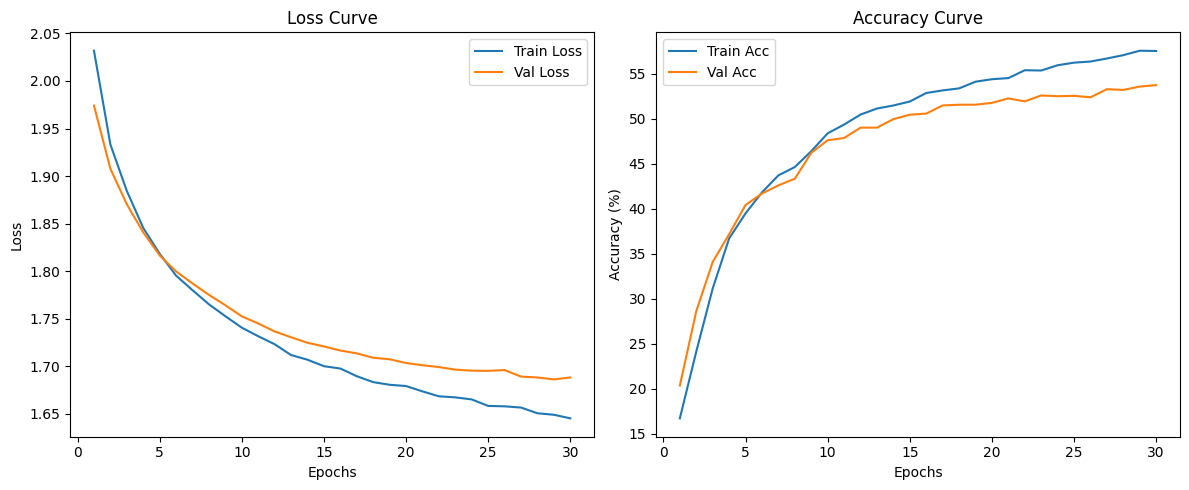

In [ ]:

# ========== Dataset ==========
class EmotionAudioDataset(Dataset):
    def __init__(self, dataframe, processor_name="MIT/ast-finetuned-speech-commands-v2", train=True):
        df = dataframe.copy().dropna().reset_index(drop=True)

        # Encode emotions to integers
        self.label_map = {emotion: i for i, emotion in enumerate(sorted(df["Emotions"].unique()))}
        self.df = df.copy()
        self.df["label"] = self.df["Emotions"].map(self.label_map)

        # Stratified split
        train_df, val_df = train_test_split(self.df, test_size=0.2, stratify=self.df["label"], random_state=42)
        self.df = train_df if train else val_df

        self.processor = AutoProcessor.from_pretrained(processor_name)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        file_path = row["Path"]
        label = row["label"]
    
        try:
            waveform, sample_rate = torchaudio.load(file_path)
        except Exception as e:
            print(f"\u274c Error loading {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)  # valid dummy
    
        if waveform.shape[0] > 1:
            waveform = waveform.mean(dim=0)
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)
        waveform = waveform.squeeze()
    
        try:
            processed = self.processor(
                waveform,
                sampling_rate=16000,
                return_tensors="pt",
                padding="max_length",
                max_length=16000
            )
            input_values = processed.input_values.squeeze(0)  # shape: [128, 128]
        except Exception as e:
            print(f"\u274c Error processing {file_path}: {e}")
            return torch.zeros((128, 128)), torch.tensor(0)
    
        return input_values, torch.tensor(label)

# ========== Classifier ==========
class CustomClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return self.softmax(x)


def save_checkpoint(model, optimizer, epoch, path="checkpoints/checkpoint.pth"):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, path)
    print(f"\u2705 Checkpoint saved at epoch {epoch}")

# ========== Training ==========
def train_model(model, train_loader, val_loader, label_map, num_epochs=10, learning_rate=2e-5, checkpoint_path=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.AdamW(model.classifier.parameters(), lr=learning_rate)

    train_labels = train_loader.dataset.df["label"]
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    # log for saving full metrics
    metrics_log = []

    start_epoch = 0
    if checkpoint_path and os.path.exists(checkpoint_path):
        start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

    for epoch in range(start_epoch, num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        print(f"\nEpoch {epoch+1}/{num_epochs}")
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            train_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        train_loss = total_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}%")

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        all_labels = []
        all_preds = []

        val_bar = tqdm(val_loader, desc="Validating", leave=False)
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(input_values=inputs).logits

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())

                val_bar.set_postfix(loss=loss.item(), acc=100 * correct / total)

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        f1_weighted = f1_score(all_labels, all_preds, average='weighted')
        f1_macro = f1_score(all_labels, all_preds, average='macro')

        # classification report
        target_names = list(label_map.keys())
        report = classification_report(
            all_labels, all_preds,
            target_names=target_names,
            digits=4,
            output_dict=True
        )

        print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_acc:.2f}%")
        print(f"F1 Score: {f1_weighted:.4f}")
        print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))

        save_checkpoint(model, optimizer, epoch + 1, path=f"checkpoints/epoch_{epoch+1}.pth")

        #Flatten the classification report
        flat_report = {
            f"{label}_{metric}": round(value, 4)
            for label, scores in report.items()
            for metric, value in (scores.items() if isinstance(scores, dict) else [("value", scores)])
        }

        # Save all metrics
        epoch_metrics = {
            "epoch": epoch + 1,
            "timestamp": datetime.now().isoformat(),
            "train_loss": round(train_loss, 4),
            "train_accuracy": round(train_acc, 2),
            "val_loss": round(val_loss, 4),
            "val_accuracy": round(val_acc, 2),
            "f1_weighted": round(f1_weighted, 4),
            "f1_macro": round(f1_macro, 4),
            "report": flat_report
        }

        metrics_log.append(epoch_metrics)
        with open("metrics_log.json", "w") as f:
            json.dump(metrics_log, f, indent=2)

    print("\u2705 Training complete!")

    # Plot and save curves
    total_epochs_ran = range(start_epoch + 1, start_epoch + len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(total_epochs_ran, train_losses, label='Train Loss')
    plt.plot(total_epochs_ran, val_losses, label='Val Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(total_epochs_ran, train_accs, label='Train Acc')
    plt.plot(total_epochs_ran, val_accs, label='Val Acc')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.savefig("training_curves.png")
    plt.show()


def load_checkpoint(model, optimizer, path):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"\u2705 Loaded checkpoint from epoch {checkpoint['epoch']}")
    return checkpoint['epoch']

# ========== Main ==========
if __name__ == "__main__":

    train_dataset = EmotionAudioDataset(data_path, train=True)
    val_dataset = EmotionAudioDataset(data_path, train=False)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    model = ASTForAudioClassification.from_pretrained(
        "MIT/ast-finetuned-speech-commands-v2",
        num_labels=len(train_dataset.label_map),
        ignore_mismatched_sizes=True
    )

    for param in model.parameters():
        param.requires_grad = False

    custom_clf = CustomClassifier(model.config.hidden_size, len(train_dataset.label_map))
    model.classifier = custom_clf

    for param in model.classifier.parameters(): #22rd epochic em heto darela True
        param.requires_grad = True

    train_model(
    model,
    train_loader,
    val_loader,
    label_map=train_dataset.label_map,
    num_epochs=30, 
    # checkpoint_path="checkpoints/epoch_24.pth"
    )
    
    torch.save(model.state_dict(), "Emotions_Withought_Augmentation_From_Epoch_22_Adding_Parameters_state_dict.pth")
    torch.save(model, "Emotions_Withought_Augmentation_From_Epoch_22_Adding_Parameters.pth")
    

